In [ ]:
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model

data = pd.read_csv("/content/FA-KES-Dataset.csv", encoding='latin1')
print(data.head())

      unit_id                                      article_title  \
0  1914947530  Syria attack symptoms consistent with nerve ag...   
1  1914947532  Homs governor says U.S. attack caused deaths b...   
2  1914947533    Death toll from Aleppo bomb attack at least 112   
3  1914947534        Aleppo bomb blast kills six Syrian state TV   
4  1914947535  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                     article_content source       date  \
0  Wed 05 Apr 2017 Syria attack symptoms consiste...    nna   4/5/2017   
1  Fri 07 Apr 2017 at 0914 Homs governor says U.S...    nna   4/7/2017   
2  Sun 16 Apr 2017 Death toll from Aleppo bomb at...    nna  4/16/2017   
3  Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...    nna  4/19/2017   
4  Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...    nna  7/10/2016   

  location  labels  
0    idlib       0  
1     homs       0  
2   aleppo       0  
3   aleppo       0  
4   aleppo       0  


In [ ]:
print(data.isnull().sum())
X = data.drop(columns=['labels'])
Y = data['labels']

unit_id            0
article_title      0
article_content    0
source             0
date               0
location           0
labels             0
dtype: int64


In [ ]:
voc_size = 5000
messages = X.copy()
messages.reset_index(inplace=True)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
ps = PorterStemmer()
corpus = list()
for i in range(0, len(messages)):
  review = re.sub('[^a-zA-Z]',' ', messages['article_title'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

for i in (random.sample(corpus, 10)):
  print(i)

kill russian militari chopper shot syria
air raid kill civilian east syria monitor
terrorist shell syria aleppo al baath kill injur
least dead suicid bomb hit damascu
jihadist execut three syria rebel offic monitor
syrian state tv say kill car bomb northern syria
syria regim kill civilian hama airstrik
civilian kill injur assad regim airstrik syria idlib
air strike syrian hospit kill monitor group say daili sabah
peopl kill other injur daesh car bomb eastern syria


***WORD EMBEDDING***

In [ ]:
onehot_repr = [one_hot(words,voc_size)for words in corpus]
for i in (random.sample(onehot_repr, 10)):
  print(i)

[2798, 4277, 70, 2444, 726, 2946, 2093, 2489, 4214, 1040]
[20, 3380, 4021, 4214, 3138, 1249, 3572, 3619]
[4295, 443, 694, 1045, 57, 1052, 2201, 1202, 1080, 4934, 3987]
[3867, 4496, 2616, 2676, 443, 694, 57, 618]
[4159, 70, 2598, 3518, 4153, 3836, 3397, 2598, 4214]
[525, 3879, 57, 3806, 4571, 2658, 1356, 4599, 2444, 4231]
[1080, 2423, 443, 4419, 70, 4214]
[1820, 692, 2195, 365, 57]
[1080, 752, 4852, 4590, 3429, 468, 3322, 2328]
[3016, 3452, 726, 57, 1820, 1964, 4590, 443, 3867, 4749]


In [ ]:
sent_length = 40
embedded_docs = pad_sequences(onehot_repr, padding='pre', maxlen=sent_length)
print(embedded_docs.shape)
print(embedded_docs[0])

(804, 40)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   57  726 1572 3328 4635 3272 2079]


***DEFINING BOTH MODELS***


*   RNN
*   CNN+RNN



In [ ]:
embedding_vector_features = 100
# hybrid model
model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(2))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
print(model.summary())

#RNN model
model_RNN = Sequential()
model_RNN.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model_RNN.add(LSTM(32))
model_RNN.add(Dense(1,activation='sigmoid'))
model_RNN.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
print(model_RNN.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           500000    
                                                                 
 conv1d (Conv1D)             (None, 36, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 584,769
Trainable params: 584,769
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           500000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                17024     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 517,057
Trainable params: 517,057
Non-trainable params: 0
_________________________________________________________________
None


***TRAIN TEST SPLITTING***

In [ ]:
print(embedded_docs.shape)
print(Y.shape)

X_final = np.array(embedded_docs)
Y_final = np.array(Y)
X_final.shape , Y_final.shape

x_train, x_test, y_train, y_test = train_test_split(X_final, Y_final, test_size=0.33, random_state=42)

(804, 40)
(804,)


***HYBRID CNN+RNN TRAINING***

In [ ]:
filepath = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint]
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=20, callbacks=callbacks, batch_size=128)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.5074 
Epoch 1: val_accuracy improved from -inf to 0.55639, saving model to my_best_model.hdf5
5/5 [==============================] - 7s 327ms/step - loss: 0.7029 - accuracy: 0.5074 - val_loss: 0.6874 - val_accuracy: 0.5564
Epoch 2/20
4/5 [=======================>......] - ETA: 0s - loss: 0.6632 - accuracy: 0.5586
Epoch 2: val_accuracy did not improve from 0.55639
5/5 [==============================] - 0s 30ms/step - loss: 0.6592 - accuracy: 0.5651 - val_loss: 0.7462 - val_accuracy: 0.5301
Epoch 3/20
1/5 [=====>........................] - ETA: 0s - loss: 0.6111 - accuracy: 0.6797
Epoch 3: val_accuracy did not improve from 0.55639
5/5 [==============================] - 0s 22ms/step - loss: 0.5046 - accuracy: 0.7677 - val_loss: 1.0442 - val_accuracy: 0.4624
Epoch 4/20
1/5 [=====>........................] - ETA: 0s - loss: 0.3442 - accuracy: 0.8516
Epoch 4: val_accuracy did not improve from 0.55639
5/5 [

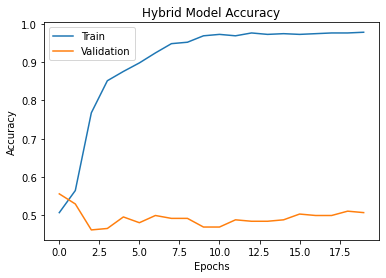

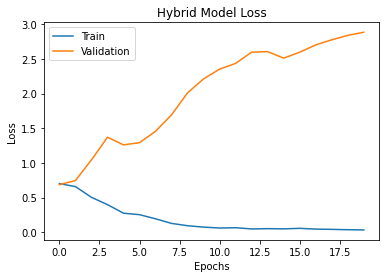

9/9 [==============================] - 1s 5ms/step
Accuracy:  55.639097744360896


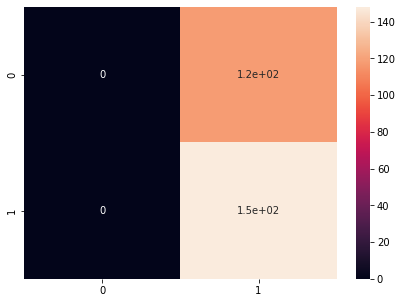

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Hybrid Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Hybrid Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model = load_model('/content/my_best_model.hdf5')
preds = model.predict(x_test)
y_pred = list()

for p in preds:
  y_pred.append(1 if p>=0.5 else 0)

Y_pred = np.array(y_pred)
df_cm = confusion_matrix(y_test, Y_pred)
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)

print('Accuracy: ', accuracy_score(y_test, Y_pred)*100)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       118
           1       0.56      1.00      0.71       148

    accuracy                           0.56       266
   macro avg       0.28      0.50      0.36       266
weighted avg       0.31      0.56      0.40       266



***RNN TRAINING***

In [ ]:
filepath = 'my_best_model_RNN.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_accuracy',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')

callbacks = [checkpoint]
history_RNN = model_RNN.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=20, callbacks=callbacks, batch_size=128)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.4740 
Epoch 1: val_accuracy improved from -inf to 0.48872, saving model to my_best_model_RNN.hdf5
5/5 [==============================] - 5s 235ms/step - loss: 0.6955 - accuracy: 0.4740 - val_loss: 0.6927 - val_accuracy: 0.4887
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.7249
Epoch 2: val_accuracy improved from 0.48872 to 0.51504, saving model to my_best_model_RNN.hdf5
5/5 [==============================] - 0s 72ms/step - loss: 0.6582 - accuracy: 0.7249 - val_loss: 0.6960 - val_accuracy: 0.5150
Epoch 3/20
1/5 [=====>........................] - ETA: 0s - loss: 0.6093 - accuracy: 0.7734
Epoch 3: val_accuracy did not improve from 0.51504
5/5 [==============================] - 0s 22ms/step - loss: 0.5640 - accuracy: 0.7509 - val_loss: 0.8359 - val_accuracy: 0.4812
Epoch 4/20
1/5 [=====>........................] - ETA: 0s - loss: 0.4500 - accuracy: 0.8125
Epoch 4:

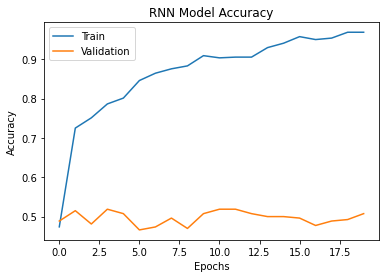

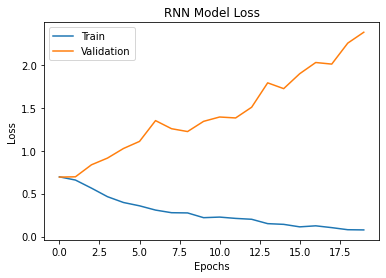

9/9 [==============================] - 1s 3ms/step
Accuracy:  51.8796992481203


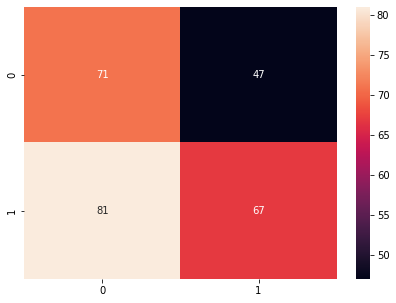

In [ ]:
plt.plot(history_RNN.history['accuracy'])
plt.plot(history_RNN.history['val_accuracy'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model = load_model('/content/my_best_model_RNN.hdf5')
preds = model.predict(x_test)
y_pred = list()

for p in preds:
  y_pred.append(1 if p>=0.5 else 0)

Y_pred = np.array(y_pred)
df_cm = confusion_matrix(y_test, Y_pred)
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True)

print('Accuracy: ', accuracy_score(y_test, Y_pred)*100)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.47      0.60      0.53       118
           1       0.59      0.45      0.51       148

    accuracy                           0.52       266
   macro avg       0.53      0.53      0.52       266
weighted avg       0.53      0.52      0.52       266

